## Identify the "start of climate change" 
The algorithm is as follows, applied to a variable (Y):

1. Identify inflection (T0) point as "start of climate change": point where dY/dt != 0 for remainder of record
2. Compute trend (ω) from that point forward
3. Compute ToE as a timescale: ToE = 2 σ / ω
4. Year of detection = T0 + ToE

In [1]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')

### Open Data then select a region

In [43]:
variables = ['SST', 'Chl_surf', 'KGP']

ds = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds = ds[variables].sel(length = 40)
ds

<xarray.Dataset>
Dimensions:    (member_id: 34, region: 5, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    length     float64 40.0
  * region     (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Data variables:
    SST        (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    Chl_surf   (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    KGP        (time, member_id, region) float64 dask.array<chunksize=(90, 34, 5), meta=np.ndarray>

In [44]:
region = 'Atlantic Quadrant'
ds_djf = ds.sel(region = region)
ds_djf


<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    length     float64 40.0
    region     <U17 'Atlantic Quadrant'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [45]:
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_mean

Standard deviation of anomalies

In [46]:
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
#ds_ref_std

### calculate and plot the anomalies relative to the reference

In [47]:
forced = ds_djf.mean('member_id')     
anom_f = forced - ds_ref_mean
#anom_f

Text(0.5, 1.0, 'Daily growth rate anomaly: Atlantic Quadrant')

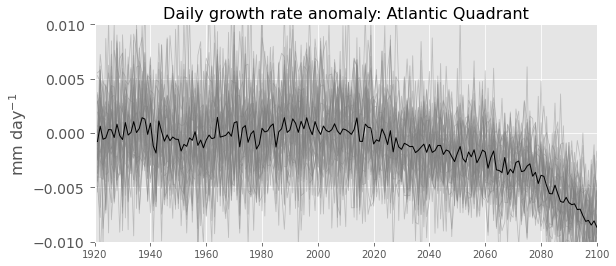

In [48]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(1,1)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf[v].long_name} anomaly: {region}', fontsize = 16)

## Calculate cumulative integrals

In [49]:
x = anom_f['time'] # The coordinate to integrate along.

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y_k = anom_f['KGP'].values # Values to integrate.
y_int_k = xr.full_like(anom_f['KGP'], fill_value=0)
y_int_k.values = integrate.cumtrapz(y_k, x, initial=0)

y_t = anom_f['SST'].values # Values to integrate.
y_int_t = xr.full_like(anom_f['SST'], fill_value=0)
y_int_t.values = integrate.cumtrapz(y_t, x, initial=0)

y_c = anom_f['Chl_surf'].values # Values to integrate.
y_int_c = xr.full_like(anom_f['Chl_surf'], fill_value=0)
y_int_c.values = integrate.cumtrapz(y_c, x, initial=0)

In [57]:
# # Isolate the climate change signal
# x = anom_f['time'] # The coordinate to integrate along.
# for l in range(len(x)): # krill
#     if all(y_int_k[l:] < 0): ndx_k = l
#     break
# #krill        
# x_cc_k, y_cc_k = x[ndx_k:], y_int_k[ndx_k:]
        
# for l in range(len(x)): # chlorophyll
#     if all(y_int_c[l:] < 0): ndx_c = l
#     break
# #chlorophyll        
# x_cc_c, y_cc_c = x[ndx_c:], y_int_c[ndx_c:]

# for l in range(len(x)): # temp
#     if all(y_int_t[l:] > 0): ndx_t = l    
#     break
# #sst        
# x_cc_t, y_cc_t = x[ndx_t:], y_int_t[ndx_t:]

# #TEST
# plt.figure(figsize=(15, 4))
# plt.plot(x, y_int_k)
# plt.plot(x_cc_k, y_cc_k, 'o')
# plt.plot(x, y_int_c)
# plt.plot(x_cc_c, y_cc_c, 'o')


NameError: name 'ndx_k' is not defined

The idea here is that you're looking for a representation of the force trend. Which gives you a magnitude of quantity per time and then you divide the standard deviation by that quantity per time, and you're left with time.

* t * t sigma / by the trend gives you a time scale.
    * 2sigma / mean = timescale
* Time the year of detection is T naught plus t o.
    * tnaught + toe


## Regression analysis
A generalized least-squares model with a ﬁrst-order autoregressive error term (AR(1)) was applied to time series of the annual maxima (SST) or minima (other variables) using R package ‘nlme’ 72 :

In [51]:
kgp_yr = 1951 #y_cc_k.time[0]
chl_yr = 2006 #y_cc_c.time[0]
sst_yr = 1950 #y_cc_t.time[0]

x = ds_djf['time'] # The coordinate to integrate along.
y_k = anom_f['KGP']
x_k, y_k = x[kgp_yr-1920:], y_k[kgp_yr-1920:]

beta_k = np.polyfit(x_k, y_k, 1)
bf_k = beta_k[1] + beta_k[0]*x_k
###
y_c = anom_f['Chl_surf']
x_c, y_c = x[chl_yr-1920:], y_c[chl_yr-1920:]

beta_c = np.polyfit(x_c, y_c, 1)
bf_c = beta_c[1] + beta_c[0]*x_c
###
y_t = anom_f['SST']
x_t, y_t = x[sst_yr-1920:], y_t[sst_yr-1920:]

beta_t = np.polyfit(x_t, y_t, 1)
bf_t = beta_t[1] + beta_t[0]*x_t

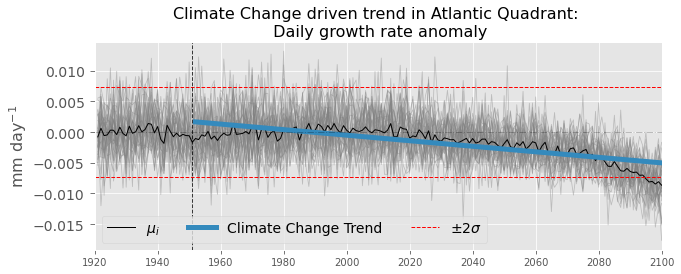

In [52]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:  # plots all ensemble members
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean
#~~~~~~~~~~~~~~ Plot Best Fit of Climate Change~~~~~~
ax.plot(x_k, bf_k, color = 'C1', linewidth = 5, label = 'Climate Change Trend') # full time series
#~~~~~~~~~~~ Plot 2 Sigma ~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma

ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma

#ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
#~~~~~~~~~~~~~~ add reference lines ~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(kgp_yr, lw=1, color='k', linestyle='--', alpha = .75)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'Climate Change driven trend in {region}: \n {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

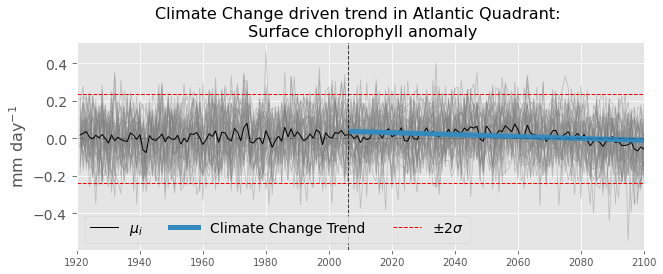

In [53]:
v = 'Chl_surf'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:  # plots all ensemble members
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean
#~~~~~~~~~~~~~~ Plot Best Fit of Climate Change~~~~~~
ax.plot(x_c, bf_c, color = 'C1', linewidth = 5, label = 'Climate Change Trend') # full time series
#~~~~~~~~~~~ Plot 2 Sigma ~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
#~~~~~~~~~~~~~~ add reference lines ~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(chl_yr, lw=1, color='k', linestyle='--', alpha = .75)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'Climate Change driven trend in {region}: \n {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

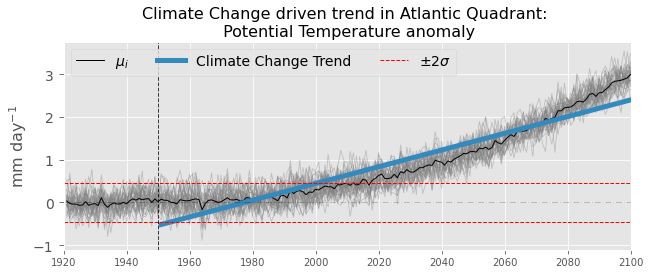

In [54]:
v = 'SST'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:  # plots all ensemble members
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean
#~~~~~~~~~~~~~~ Plot Best Fit of Climate Change~~~~~~
ax.plot(x_t, bf_t, color = 'C1', linewidth = 5, label = 'Climate Change Trend') # full time series
#~~~~~~~~~~~ Plot 2 Sigma ~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
#~~~~~~~~~~~~~~ add reference lines ~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(sst_yr, lw=1, color='k', linestyle='--', alpha = .75)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'Climate Change driven trend in {region}: \n {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

### Redo TOE

In [ ]:
%%time
ds_trend_sign = xr.where(
    ds_djf.sel(time=slice(2091, 2100)).mean(['time', 'member_id']) >= ds_ctrl_mean, 1., -1
).compute()
ds_trend_sign